# Todo

* Make decent vanilla classifier
     * ~~Resize instead of cropping~~
     * Stop using new_whale as class
* Make siamese model
* Optimize image size
* Optimize dupilcate detector
* Optimize augmentation
* Optimize tail detector and crop
    * Use ResNext50 as opposed to ResNet34
    * Add more data from other kaggle users

# Imports

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# Set up model

In [4]:
PATH= 'D:/msc/kaggle_data/whales/'

In [5]:
model=resnext50
bs=4
sz=299

In [6]:
def get_data(sz):
    tfms = tfms_from_model(model, sz, crop_type=CropType.NO, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, trn_name='train', val_name='validation', test_name= 'test')

In [7]:
learn = ConvLearner.pretrained(model, get_data(sz))

In [13]:
learn.lr_find()

 77%|████████████████████████████████████████████████████▍               | 863/1119 [07:39<02:16,  1.88it/s, loss=35.1]

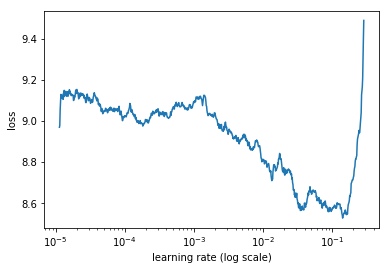

In [15]:
learn.sched.plot(n_skip_end=30)

In [10]:
lr=2e-3

In [17]:
learn.fit(lr,3, cycle_len=1, cycle_mult=2)

  1%|▍                                                                      | 6/1119 [00:05<16:18,  1.14it/s, loss=9.1]
epoch      trn_loss   val_loss   accuracy                                                                              
    0      8.653954   7.487363   0.147124  
    1      8.114615   6.587223   0.225664                                                                              
    2      7.747072   6.495569   0.230088                                                                              
    3      7.571154   6.11956    0.234513                                                                              
    4      7.275803   5.798278   0.247788                                                                              
    5      7.005576   5.698104   0.253319                                                                              
    6      6.825414   5.682917   0.254425                                                                           

[5.682917052665643, 0.25442477876106195]

In [8]:
#learn.save('299_last_layer_nocrop')
learn.load('299_last_layer_nocrop')

In [11]:
lrs = np.array([lr/9,lr/3,lr])

In [12]:
learn.unfreeze()
learn.fit(lrs,3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      7.874274   6.331018   0.221239  
    1      7.740196   5.982207   0.22677                                                                               
    2      7.633639   5.883034   0.224558                                                                              
    3      7.592475   5.718005   0.228982                                                                              
    4      7.519968   5.48413    0.234513                                                                              
    5      7.227295   5.401085   0.22677                                                                               
    6      7.435877   5.36484    0.230088                                                                              



[5.364840196297232, 0.23008849557522124]

In [14]:
#learn.save('299_full_nocrop')
learn.load('299_full_nocrop')

# Submit

## Run predictor

In [15]:
log_preds = learn.TTA(is_test=True)

In [16]:
log_probs = log_preds[0]

In [17]:
probs = np.mean(np.exp(log_probs),0)

In [18]:
best_pred_numbers = np.argsort(-probs,1)[:,:5]

In [19]:
lookup_names = np.vectorize(lambda i: learn.data.classes[i])
best_pred_names = lookup_names(best_pred_numbers)

In [20]:
filenames = np.array([fn[5:] for fn in learn.data.test_ds.fnames]).reshape(-1,1)

## Fix duplicates

In [21]:
duplicates_df = pd.read_csv('duplicates.csv')

In [22]:
for i in range(len(duplicates_df)):
    findex = np.where(filenames == duplicates_df.iloc[i]['file'])[0][0]
    best_pred_names[findex,:] = np.concatenate([np.array(list(eval(duplicates_df.iloc[i]['names']))), best_pred_names[findex,:]])[:5]

In [23]:
best_pred_names[:7]

array([['new_whale', 'w_7875b79', 'w_73d5489', 'w_1da7080', 'w_b9e00eb'],
       ['new_whale', 'w_d88328d', 'w_ee17a08', 'w_2d99a0c', 'w_9ca943b'],
       ['new_whale', 'w_6c803bf', 'w_18eee6e', 'w_43be268', 'w_d2be6cc'],
       ['new_whale', 'w_dbda0d6', 'w_f19faeb', 'w_cae7677', 'w_0e737d0'],
       ['new_whale', 'w_18eee6e', 'w_43be268', 'w_d2be6cc', 'w_0e737d0'],
       ['new_whale', 'w_ab4cae2', 'w_7554f44', 'w_b074cdf', 'w_693c9ee'],
       ['w_3d66298', 'new_whale', 'w_95874a5', 'w_9b401eb', 'w_17ee910']], dtype='<U9')

## Submit

In [24]:
subm = np.concatenate([filenames, best_pred_names], axis = 1)
name = 'subm_fastai_base_duplicates_nocrop_full.csv'
np.savetxt(name, subm, fmt = '%s, %s %s %s %s %s', header = 'Image,Id', comments = '')